<a href="https://colab.research.google.com/github/bdesgarennes/Analytics/blob/main/Notebook_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Foodstamps in Democrat vs Republican Districts**

In [14]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

## Reasoning and Hypothesis

In modern society, there are people living in the United States who are impacted by unemployment, low wages, and disibilities and need nutritional support and public aid. Historically, it is a common Republican argument that Democrats want "handouts" and free government assistance as seen by the below video and articles: 

[FOX: Democrats Want Americans Dependent on Government Handouts](https://youtu.be/Zd61RiA4A4M)

[Republican Policy Committee: Democrats Plot Massive Government Handouts](https://www.rpc.senate.gov/policy-papers/democrats-plot-massive-government-handouts)

[NY Post: Democrats’ push for guaranteed income is a slap in the face to working people](https://nypost.com/2022/09/20/democrats-push-for-guaranteed-income-is-a-slap-in-the-face-to-working-people/)

We wanted to see if the data backs up these theories in relation to Democratic cities in the United States and see if a common government support "handout", foodstamps, is really more prevelant in cities that are run by Democrats. 

For some background, the current criteria for obtaining foodstamps is as follows. (The data we have is from 2020 so criteria may have slightly shifted since).  

*   Gross Monthly Income: Must be at or below 130% of poverty line.
*   Net Income or houshold income: After deductions are applied must be at or below poverty line
* Assets: Households without a member who is age 60 or older or who has a disability must have assets of \$2,750 or less, and households with such a member must have assets of $4,250 or less

Although food stamps are a Federal program, in order to recieve benefits one has to apply to recieve the benefit and have a valid ID. 

**Hypothesis:** The districts with individuals who recieve the most amount of foodstamps are mostly Democratic.

## Read in Census Data

In [54]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B22010_001E,B22010_002E,B22010_005E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Recieved Foodstamps', 'No Foodstamps','Less than 10k','More than 200k', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Recieved Foodstamps', "No Foodstamps",'Less than 10k','More than 200k', 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Recieved Foodstamps,No Foodstamps,Less than 10k,More than 200k,district number,State
0,289474,29587,259887,14153,19390,10,Michigan
1,299804,39629,260175,23793,10899,4,Mississippi
2,278057,68311,209746,27728,19574,14,Michigan
3,306685,33726,272959,19036,12208,1,Michigan
4,285554,28441,257113,26481,12412,3,Mississippi


## Read in Party Data

In [55]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


## Create Foodstamp Percentages

In [57]:
# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df['Total Households'])
acs_df["Recieved Foodstamps"] = pd.to_numeric(acs_df['Recieved Foodstamps'])
acs_df['No Foodstamps'] = pd.to_numeric(acs_df['No Foodstamps'])
acs_df['Less than 10k'] = pd.to_numeric(acs_df['Less than 10k'])
acs_df['More than 200k'] = pd.to_numeric(acs_df['More than 200k'])


# Compute some new columns based on the existing columns for later visualization
acs_df['% of households foodstamps'] = (100*acs_df['Recieved Foodstamps'])/acs_df['Total Households']
acs_df['% of households no foodstamps'] = (100*acs_df['No Foodstamps'])/acs_df['Total Households']
acs_df['% Less than 10k'] = (100*acs_df['Less than 10k'])/acs_df['Total Households']
acs_df['% More than 200k'] = (100*acs_df['More than 200k'])/acs_df['Total Households']

# now let's look at the data again
acs_df.head()

,Total Households,Recieved Foodstamps,No Foodstamps,Less than 10k,More than 200k,district number,State,% of households foodstamps,% of households no foodstamps,% Less than 10k,% More than 200k
0,289474,29587,259887,14153,19390,10,Michigan,10.220952,89.779048,4.889213,6.698356
1,299804,39629,260175,23793,10899,4,Mississippi,13.218303,86.781697,7.936185,3.635375
2,278057,68311,209746,27728,19574,14,Michigan,24.567265,75.432735,9.972056,7.039564
3,306685,33726,272959,19036,12208,1,Michigan,10.996951,89.003049,6.207020,3.980632
4,285554,28441,257113,26481,12412,3,Mississippi,9.959938,90.040062,9.273552,4.346638


## Merge Dataframes

In [58]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

merged_df=merged_df[merged_df['Party']!= "L"]

merged_df.describe()



,Total Households,Recieved Foodstamps,No Foodstamps,Less than 10k,More than 200k,district number,% of households foodstamps,% of households no foodstamps,% Less than 10k,% More than 200k
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,292477.410138,36322.486175,256154.923963,17612.700461,28538.569124,10.175115,12.611127,87.388873,6.052506,9.726725
std,33709.431023,15221.763056,37484.702130,6053.283209,18921.413644,10.663517,5.631805,5.631805,2.107973,6.424471
min,183319.000000,9227.000000,140888.000000,6021.000000,5296.000000,0.000000,2.805607,52.863661,2.208934,2.025905
25%,273664.500000,26289.250000,235388.000000,13415.500000,14842.500000,3.000000,8.666167,84.464051,4.644085,5.178620
50%,292530.000000,34679.000000,257910.500000,16626.500000,22554.500000,6.000000,11.700921,88.299079,5.683421,7.634268
75%,312015.750000,43307.250000,278593.000000,21017.750000,37015.750000,13.000000,15.535949,91.333833,7.039841,12.691753
max,448949.000000,125624.000000,410144.000000,44929.000000,111988.000000,53.000000,47.136339,97.194393,16.858153,41.846370


In [59]:
# let's take a look at the party breakdown 
merged_df['Party'].value_counts()

D    233
R    201
Name: Party, dtype: int64

There are 32 more Democratic districts than Republican.

## Barplot: Median % of Households Receiving Foodstamps

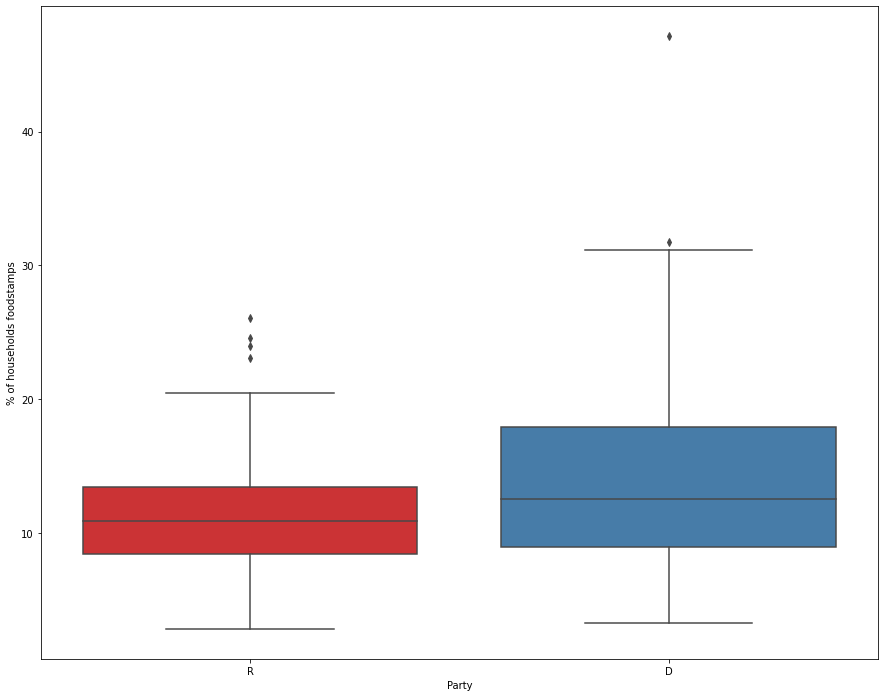

In [60]:
fig, ax = plt.subplots(figsize=(15, 12))

ax = sns.boxplot(x='Party', y='% of households foodstamps', data=merged_df, ax=ax,palette="Set1")

median = merged_df.groupby("Party")["% of households foodstamps"].median()

# show the graph

plt.show()

The above box-plot showcases that Democratic districts have a wider range of percentages of households that receive food-stamps than the range of Republican districts. From the box-plot we can also see that for Democratic districts the median as well as all quartiles are above that of Republican districts. We also notice that the Republican districts have four outliers and Democratic districts have two. 

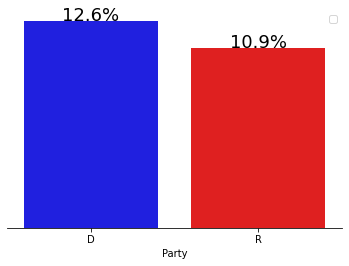

In [61]:
median = merged_df.groupby("Party")["% of households foodstamps"].median()

colors= {"D":"blue","L":"gold", "R": "red"}

ax=sns.barplot(x=median.index, y=median.values, palette=colors)

ax.yaxis.set_visible(False)

for i, value in enumerate(median.values):
    ax.text(i, value, f'{value:.1f}%', ha="center", fontsize=18)

sns.despine(left=True)

plt.legend()
plt.show()

This bar chart showcascases the difference in the medians between the two parties. 

## Top 10 and Bottom 10 Districts

The ten districts with the highest percentages of household food-stamps are comprised of nine Democratic districts and one Republican district. 

The 15th District of New York has the highest percentages of households with food-stamps at 47.13%. The 15th District of NY is located entirely within the Bronx. More specifically the district covers the South and West portion of the Bronx in NYC. The district is considered the most diverse area in the country by the Census Bureau. 

The one Republican district in the top ten is district 5 of Kentucky. This district is in Southeastern Kentucky and represents much of the eastern Kentucky Coalfield. As of the 2010 US census the district had the highest percentage of White Americans. 

In [62]:
df_descending = merged_df.sort_values("% of households foodstamps", ascending=False)

desc= df_descending[["Party","% of households foodstamps", "State", "district number"]]

# bottom 10 
print(desc.head(10))

    Party  % of households foodstamps         State  district number
276     D                   47.136339      New York               15
19      D                   31.727897      New York               13
227     D                   31.121851      Michigan               13
277     D                   30.736612  Pennsylvania                2
155     D                   29.298095       Florida               24
353     D                   26.675203     Wisconsin                4
347     D                   26.293892         Texas               34
411     R                   26.068994      Kentucky                5
248     D                   26.042580          Ohio               11
109     D                   25.837134    California               16


The ten districts with the lowest percentage of households receiving food-stamps is comprised of two Republican districts and eight Democratic districts.

The district with the smallest percentage of food-stamps in the US is Texas district 3. This district encompasses the suburbs North and Northeast of Dallas and is said to be one of the most Republican districts in Texas.

The second smallest percentage of food-stamps is district 11 of New Jersey. District 11 has been represented by Republican's from 1984 but just recently changed to Democrat representation in 2019.

In [64]:
df_ascending = merged_df.sort_values("% of households foodstamps")

asc = df_ascending[["Party","% of households foodstamps", "State", "district number"]]

# top 10 
print(asc.head(10))

    Party  % of households foodstamps       State  district number
315     R                    2.805607       Texas                3
242     D                    3.232621  New Jersey               11
403     D                    3.561407     Georgia                6
216     R                    3.751107    Missouri                2
112     D                    3.766951  California               18
62      D                    3.838902    Virginia               10
264     D                    3.918898    New York                3
27      D                    3.952794  New Jersey                5
28      D                    4.193566  New Jersey                7
324     D                    4.318915    Virginia               11


## % of Households Receiving Foodstamps Distribution (Dems)

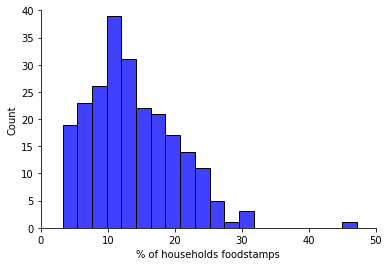

In [65]:
df_dem = merged_df[merged_df['Party']== "D"]

sns.histplot(df_dem["% of households foodstamps"], bins = 20, color="blue")

plt.xlim(0, 50)

plt.ylim(0,40)

sns.despine()



The histogram above shows how Democratic districts have a skewed right distribution. 

## % of Households Receiving Foodstamps Distribution (Reps)

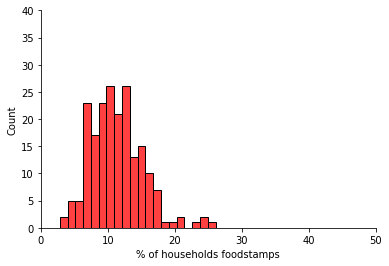

In [66]:
df_rep = merged_df[merged_df['Party']== "R"]

sns.histplot(df_rep["% of households foodstamps"],bins = 20, color="red")

plt.xlim(0, 50)

plt.ylim(0,40)

sns.despine()

The histrogram for Republican districs shows a relatively normal distriution. When compared to Democratic graph, this is far more concentrated around a center. While the centers for both graphs look relatively similar, there is a much higher count of Democratic districts who have more than 20% of households recieving foodstamps. 

## Relationship Between Food-Stamps and Median Household Income

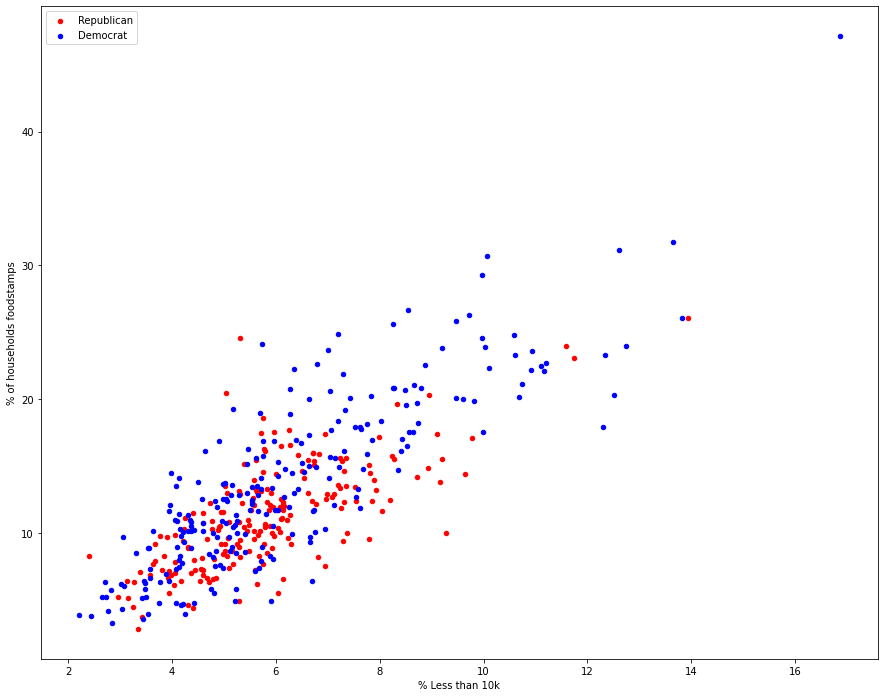

In [68]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(y='% of households foodstamps', x='% Less than 10k', c='red',label='Republican', ax=ax)
D.plot.scatter(y='% of households foodstamps', x='% Less than 10k',c='blue',label='Democrat', ax=ax)


plt.show()


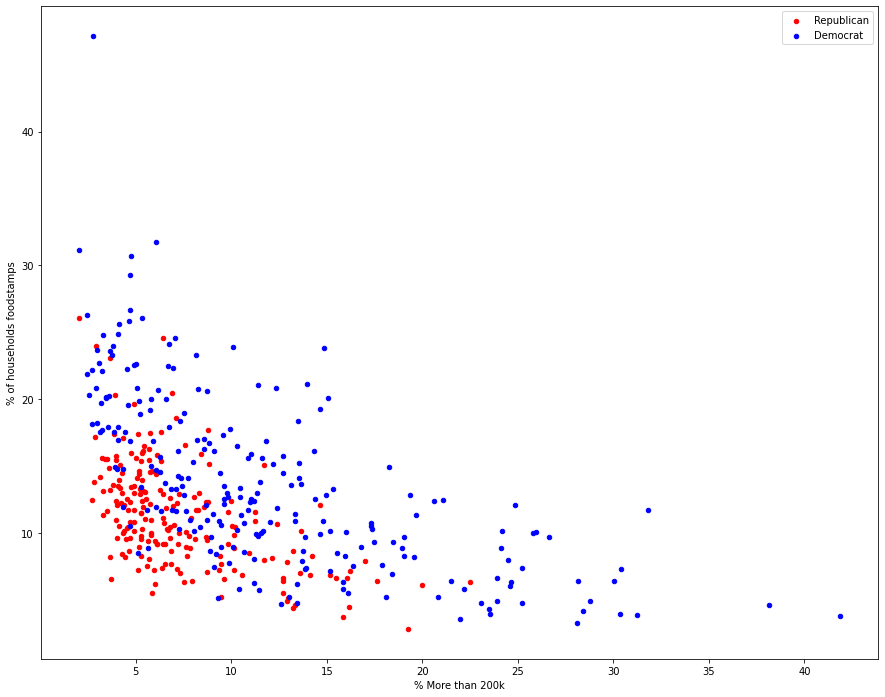

In [69]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(y='% of households foodstamps', x='% More than 200k', c='red',label='Republican', ax=ax)
D.plot.scatter(y='% of households foodstamps', x='% More than 200k',c='blue',label='Democrat', ax=ax)


plt.show()

Add corr fig - add sum - add more in results - add line of fit red vs blue (if time)

## Results of Analysis 

Given the results above and the analysis we just discussed, we can conclude that overall there is support for our hypothesis that Democratic districts have a higher percentage of people receiving foodstamps. However, Democratic districts vere towards the extreems on both sides and Republican districts have a more normal distribution.